In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import fetch_miyawaki2008
import pylab as plt
import os.path as op
from tqdm import tqdm

sns.set_style('white')
%matplotlib inline

## Encoding models for visual stimuli

Thus far we have focused on using predictive models for decoding. That is - predicting states of the world using brain activity. However, it is possible to do the reverse: predict brain activity using information about the world. These are known as encoding models. It is possible to fit encoding models using nilearn and scikit-learn. Here we'll use an encoding model to predict fMRI data from visual stimuli, using the dataset from Miyawaki et al., 2008.

### The Miyawaki Dataset
Participants were shown images, which consisted of random 10x10 binary (either black or white) pixels, and the corresponding fMRI activity was recorded. We will try to predict the activity in each voxel from the binary pixel-values of the presented images. Then we extract the receptive fields for a set of voxels to see which pixel location a voxel is most sensitive to.

## Preparing the Data

In [2]:
# First we load the full dataset using nilearn
dataset = fetch_miyawaki2008()
print(dataset['description'].decode('utf-8'))

Miyawaki 2008


Notes
-----
Collection of result images from MVPA investigation of the human visual systems.

This fMRI study reconstructed visual images by combining local
image bases of multiple scales. Their contrasts were independently
decoded from fMRI activity by selecting important voxels and
capitalizing on their correlation structure.

Content
-------
    :'label': Paths to text files containing session and target data
    :'func': Paths to nifti files with BOLD data
    :'mask': Path to general mask nifti that defines target volume in visual cortex
    :'mask_roi': List of paths to images with specific data ('RH' for right hemisphere, 'LH' for left hemisphere, 'Vxxx' denote visual areas)


References
----------
For more information on this dataset's structure, see
http://www.cns.atr.jp/dni/en/downloads/ fmri-data-set-for-visual-image-reconstruction

Miyawaki, Y., Uchida, H., Yamashita, O., Sato, M. A.,
Morito, Y., Tanabe, H. C., ... & Kamitani, Y. (2008).
Neuron, 60(5), 915-9

This dataset is broken up into both training and testing data. Here we will only use the training data of this study, where random binary images were shown.

In [3]:
# Training data starts after the first 12 files
fmri_random_runs_filenames = dataset.func[12:]
stimuli_random_runs_filenames = dataset.label[12:]

### Loading the Neural Data

#### Working with Multiple data files
The nilearn.input_data.MultiNiftiMasker class allows us to mask multiple Nifti files at once. We will use this to load the fMRI data, clean and mask it.

In [4]:
# This is a list of filenames, corresponding to multiple runs of the experiment
fmri_random_runs_filenames[:5]

['C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\func\\data_random_run01.nii.gz',
 'C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\func\\data_random_run02.nii.gz',
 'C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\func\\data_random_run03.nii.gz',
 'C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\func\\data_random_run04.nii.gz',
 'C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\func\\data_random_run05.nii.gz']

In [5]:
masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True, standardize=True)

### Vectorizing the data 

In [6]:
# This will mask and clean each dataset
# It outputs a list of vectorized arrays
masker.fit()
fmri_data = masker.transform(fmri_random_runs_filenames)

C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\_utils\cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


In [7]:
print('Type: ', type(fmri_data), '\n---\nLength: ', len(fmri_data))
fmri_data[0]

Type:  <class 'list'> 
---
Length:  20


array([[-0.84576047, -2.00409847, -0.63856833, ..., -0.0703331 ,
         2.00162479,  0.13446872],
       [-0.86547237, -1.7537534 , -1.17549528, ...,  0.94502133,
        -0.81782921, -0.57213769],
       [-0.39525228, -0.13824568, -0.56777185, ...,  0.97448285,
         0.69280806, -0.91134732],
       ...,
       [-1.06923005, -0.05674129, -0.05552219, ..., -0.1757492 ,
        -1.06307467, -0.27648925],
       [ 0.67326913,  2.0415803 , -0.33138947, ...,  0.81178806,
        -0.08484034, -0.06203715],
       [ 1.74079517,  1.86753125,  1.93358524, ...,  0.03240438,
         1.31066568, -2.28357008]])

## Reading in Stimuli
These files define the stimuli that are used in this dataset

In [8]:
stimuli_random_runs_filenames[:5]

['C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\label\\data_random_run01_label.csv',
 'C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\label\\data_random_run02_label.csv',
 'C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\label\\data_random_run03_label.csv',
 'C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\label\\data_random_run04_label.csv',
 'C:\\Users\\jzm0144/nilearn_data\\miyawaki2008\\label\\data_random_run05_label.csv']

Since it's a CSV, we'll again use pandas to load it. Each CSV is one run. Within each CSV, each row is one stimulus presentation, consisting of a 10x10 grid of black and white squares:

In [9]:
import pandas as pd
stimulus = pd.read_csv(stimuli_random_runs_filenames[0])
stimulus.shape

(144, 100)

### Reshaping so we can plot them 
Here we will reshape our stimulus data so we can get a feel for what they look like.

In [10]:
# shape of the binary (i-e. black and white values) image in pixels
stimulus_shape = (10, 10)

# We load the visual stimuli from the csv files
stimuli = []
for stimulus_run in stimuli_random_runs_filenames:
    stimulus = pd.read_csv(stimulus_run, header=None).values.astype(int)
    
    # Reshape so it's 10x10
    stimulus = stimulus.reshape((-1,) + stimulus_shape, order='F')
    stimuli.append(stimulus)

Let's take a look at some of these binary images:

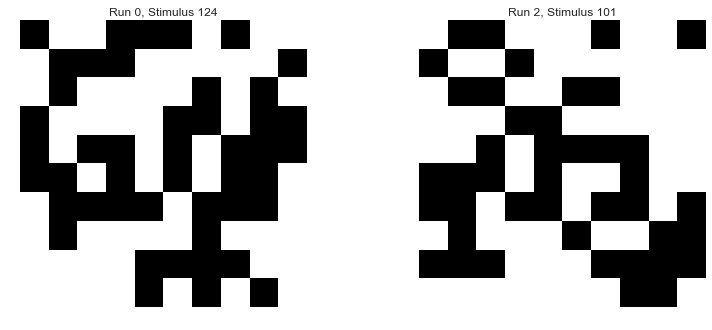

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for (run, stimulus), ax in zip([(0, 124),(2, 101)], axs):
    ax.imshow(stimuli[run][stimulus], interpolation = 'nearest', cmap = 'gray')
    ax.set_title('Run {}, Stimulus {}'.format(run, stimulus))
    ax.set_axis_off()
plt.tight_layout(w_pad = 10)

## Reshaping data for the model 
We now stack the fmri and stimulus data and remove an offset in the beginning/end. This will prep the data for our model fitting.

In [12]:
# Removing the offset (2 values) so they're aligned preperly
fmri_data = np.vstack([fmri_run[2:] for fmri_run in fmri_data])
stimuli = np.vstack([stimuli_run[:-2] for stimuli_run in stimuli]).astype(float)

fmri_data is matrix of samples x voxels

In [13]:
print(fmri_data.shape)

(2860, 5438)


We flatten the last wo dimensions of stimuli so it is a matix of samples x pixels.

In [14]:
# Flatten the stimuli
stimuli = np.reshape(stimuli, (-1, stimulus_shape[0] * stimulus_shape[1]))

print(stimuli.shape)

(2860, 100)


    Note: We don't have a fancy ImageVectorizer object so we're doing the reshaping by hand. If you were implementing this code in your own work, it may be a good idea to write your own Vectorizer object.

## Building the encoding models
Previously, we built a classifier using brain activity and labels for different stimuli that were presented. In this case, we wish to make a different kind of prediction: a continuous representation of the each voxel using the pixel data from the stimuli.

These types of models are called voxel-wise encoding models, and they use regression to predict continuous outputs from data. Specifically, we'll use Ridge regression. For each voxel we fit an independent regression model, using the pixel-values of the visual stimuli to predict the neuronal activity in this voxel.

In [15]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from tqdm import tqdm

### Cross-validating our encoding model
Using 10-fold cv, we partition the data into 10 folds. We hold out each fold of the data for testing, then fit a ridge regression to the remaining 9/10 of the data.

As this is an encoding model, We'll use stimuli as predictors and fmri_data as targets, and create predictions for the held-out 10th set.

In addition, we'll score the model using the coefficient using the coefficient of determination (R^2). This estimates the model's ability to explain variance in the neural activity.

In [16]:
from sklearn.metrics import r2_score

# Define our estimator and cross-validation objects...
estimator = Ridge(alpha=100.)
cv = KFold(n_splits=10)

Let's take a quick look at what our cross_validation is actually doing...

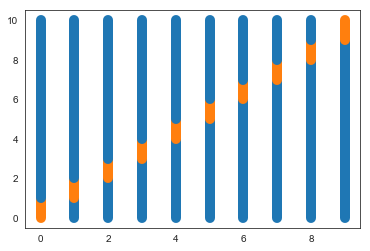

In [17]:
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(range(10))):
    ax.plot([tr, tr], [ii, ii+1], 'C0', lw=10)
    ax.plot([tt, tt], [ii, ii+1], 'C1', lw=10)

Now we'll loop through each iteration of the CV, fit the model on a subset of data, and test it on another subset of data.

In [18]:
scores = []
for train, test in tqdm(list(cv.split(fmri_data))):
    # We train the Ridge estimator on the training set
    X = stimuli.reshape(-1, 100)
    X_train = X[train]
    X_test  = X[test]
    y_train = fmri_data[train]
    y_test  = fmri_data[test]
    
    # And predict the fMRI activity for the test set
    model = Ridge(alpha=100.).fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # We compute how much variance our encoding model explains in each voxel
    scores.append(r2_score(y_test, predictions, multioutput='raw_values'))

100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


## Mapping the encoding scores on the brain
We've fit an encoding model for each voxel of the brain. Now we can inspect the model's performance at each location.

To plot the scores onto the brain, we create a Nifti1Image using the scores output by our model. We'll again use the NiftiMasker to convert it back to volume space.

In [19]:
cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0
# Bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\_utils\cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\plotting\displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
E:\Janzaib_Masood\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Janzaib_Masood\Anaconda\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label

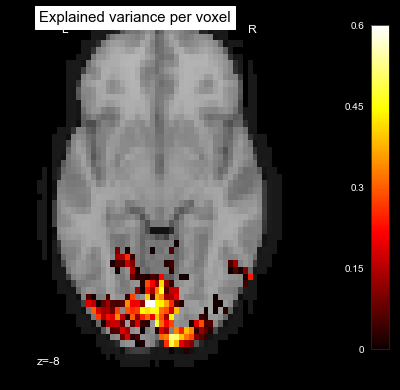

In [20]:
from nilearn.plotting import plot_stat_map
display = plot_stat_map(score_map_img, bg_img = dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title = 'Explained variance per voxel')

plt.gcf().set_size_inches(5, 5)

### What does it mean to havea  "good" score in regression?
In regression we're predicting a continuous variable. If we do a "good" job of predicting, then our predictions should be correlated with the "True" activity of the voxel. Let's visualize a good and bad voxel below:

E:\Janzaib_Masood\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0.5, 'Voxel activity (predicted)'),
 Text(0.5, 0, 'Voxel activity (true)'),
 Text(0.5, 1.0, 'A bad voxel')]

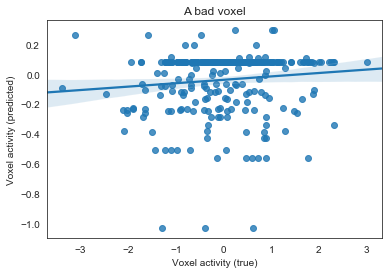

In [21]:
ax = sns.regplot(y_test[:, 0], predictions[:, 0])
ax.set(title="A bad voxel", xlabel="Voxel activity (true)",
                            ylabel="Voxel activity (predicted)")

[Text(0, 0.5, 'Voxel activity (predicted)'),
 Text(0.5, 0, 'Voxel activity (true)'),
 Text(0.5, 1.0, 'A good voxel')]

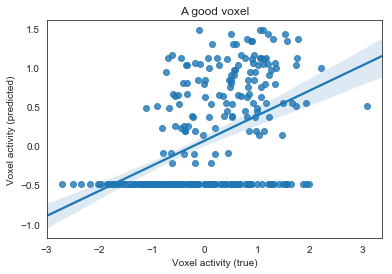

In [23]:
good_scores_ixs = np.where(cut_score > .3)[0]
this_score_ix = good_scores_ixs[10]

ax = sns.regplot(y_test[:, this_score_ix], predictions[:, this_score_ix])
ax.set(title="A good voxel", xlabel="Voxel activity (true)",
                             ylabel="Voxel activity (predicted)")

### Thresholding our scores and making a final plot
We may also want to threshold our scores so that only "valid" scores are plotted. We'll do this thresholding below.

In [25]:
from nilearn.image import threshold_img
thresholded_score_map_img = threshold_img(score_map_img, threshold=0.2)

We'll highlight a few voxels of particular interest. We'll inspect these more closely later on.

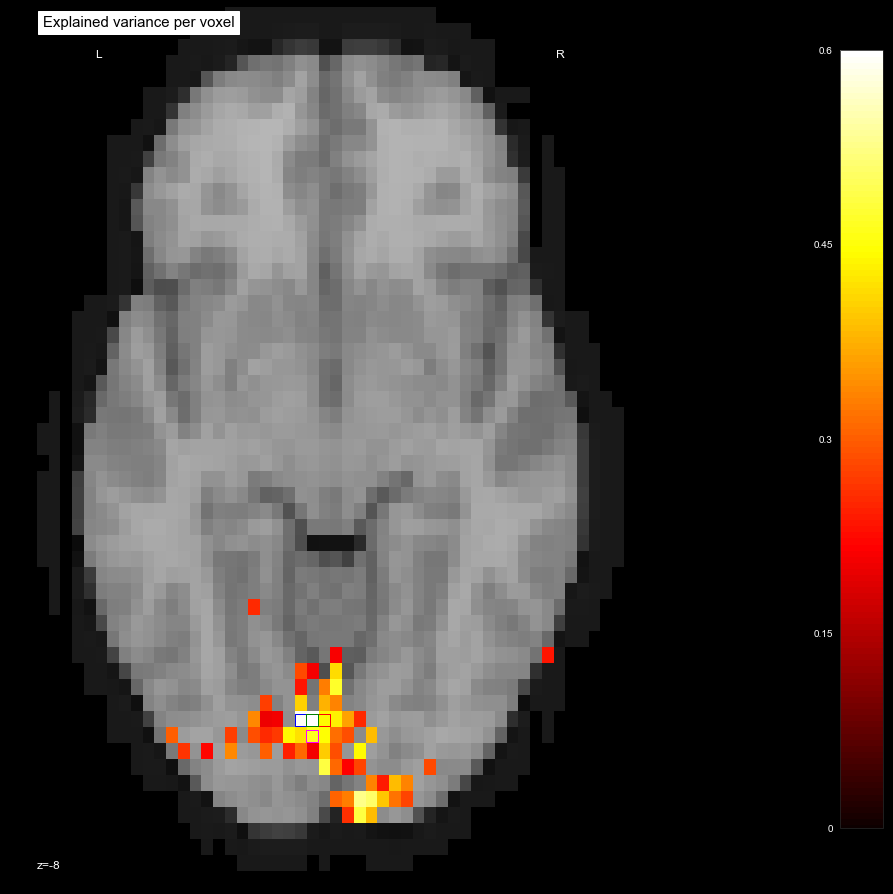

In [32]:
from nilearn.image.resampling import coord_transform

def index_to_xy_coord(x, y, z = 10):
    '''Transforms data index to coordinates of the background + offset'''
    coords = coord_transform(x, y, z,
                             affine=thresholded_score_map_img.affine)
    return np.array(coords)[np.newaxis, :] + np.array([0, 1, 0])


xy_indices_of_special_voxels = [(30, 10), (32, 10), (31, 9), (31, 10)]

display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                       title = 'Explained variance per voxel')

# creating a number for each voxel and adding it to the statistical map
for i, (x, y) in enumerate(xy_indices_of_special_voxels):
    display.add_markers(index_to_xy_coord(x, y), marker_color='none',
                        edgecolor=['b', 'r', 'magenta', 'g'][i],
                        marker_size=140, marker='s')
    

# reset figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(12, 12)

## Model Introspection: Estimating receptive fields
Now that we can see the distribution of scores across the voxels of interest, let's take a closer look at the receptive fields for the four marked voxels. It only makes sense to do this for voxels with a relatively high prediction score.

A voxel's receptive field is the region of a stimulus (like an image) where the presence of an object (like a white instead of a black pixel), results in a change in activity in the voxel.

In our case the receptive field is just vector of 100 regression coefficients (one for each pixel) reshaped into the 10x10 form of the original images.

In [34]:
from sklearn.linear_model import LassoLarsCV, RidgeCV
from matplotlib import gridspec
from matplotlib.patches import Rectangle

# Automatically estimate the sparsity by cross-validation
lasso = LassoLarsCV(max_iter=10)
# Or find a smooth set of coefficients
ridge = RidgeCV(alphas=np.logspace(-2, 2, 10))

# This is the model we will actually use
model = lasso

# These are the indices for the voxels for which we'll estimate a receptive field.
voxels_to_fit = [1780, 1951, 2131, 1935]

# This is a pixel we'll highlight in each model's receptive field.
marked_pixel = (4, 2)

Next, We'll loop through each voxel, fit a regression model for it, and visualize the coefficients of that model.

We'll plot the voxels so that the plots represent the relative positions of voxels.

E:\Janzaib_Masood\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Janzaib_Masood\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Janzaib_Masood\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Janzaib_Masood\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the d

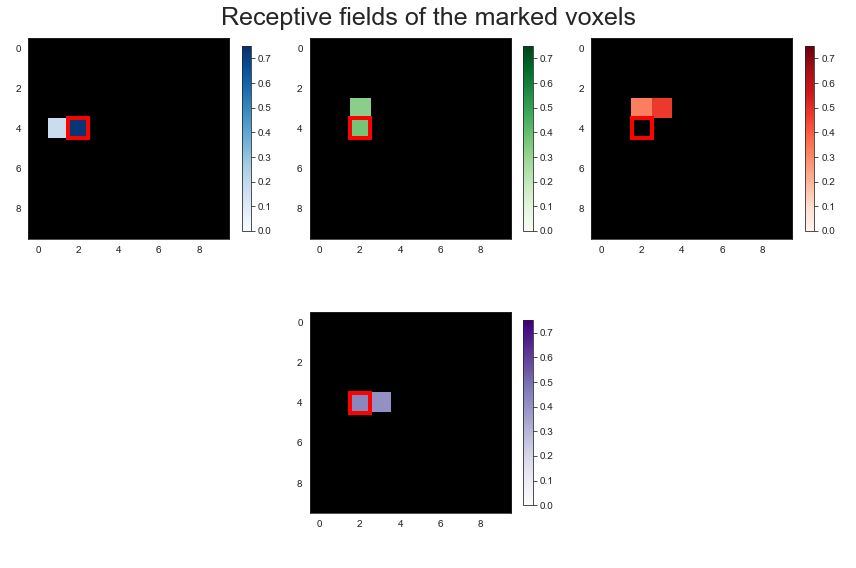

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs_to_plt = [0, 1, 2, 4]

# We fit the model for each of the three voxels fo the upper row
for i, index in enumerate(voxels_to_fit):
    #-------------Fit the model----------
    y = fmri_data[:, index]
    model.fit(stimuli, y)
    
    #We reshape the coefficients into the form of the original images.
    rf = model.coef_.reshape((10, 10))
    
    # ----- Visualize the RF -------
    # add a black background
    ax = axs.ravel()[axs_to_plt[i]]
    ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
    ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                      cmap=['Blues', 'Greens', 'Reds', 'Purples'][i],
                      vmin=0., vmax=0.75)
    
    # add the marked pixel
    ax.add_patch(Rectangle(
                 (marked_pixel[1] - .5, marked_pixel[0] - .5), 1, 1,
                 facecolor="none", edgecolor='r', lw=4))
    plt.colorbar(ax_im, ax=ax, shrink=.7)
    
for ax in axs.ravel()[[3, 5]]:
    ax.set_axis_off()
fig.suptitle('Receptive fields of the marked voxels', fontsize=25)
plt.tight_layout()